# 목차
1. 필요한 라이브러리 임포트 및 설정
2. 데이터 로드 및 전처리
- 2.1 MHealth 데이터셋 로드 및 전처리 (메모리 관리 적용)
- 2.2 데이터 검증 및 전처리
3. MergeData.csv 데이터 처리 및 전처리
- 3.1 MergeData.csv를 Parquet로 변환하여 저장 (데이터 저장 형식 최적화)
- 3.2 데이터 검증 및 전처리
4. 데이터셋 결합 및 스케일링 (메모리 관리 적용)
5. 데이터셋 분할 및 데이터 검증
6. 모델 정의 및 학습
- 6.1 MobileNetV2 1D 모델 구현
- 6.2 모델 프루닝 적용
- 6.3 지식 증류(Knowledge Distillation) 적용
- 6.4 모델 학습 (메모리 관리 적용)
7. 모델 저장 및 배포를 위한 최적화
- 7.1 모델 양자화 및 TorchScript 변환
8. 실시간 예측 함수 구현 및 최적화
9. MergeData.parquet 데이터에 대한 예측 및 레이블 추가 (메모리 관리 적용)
- 9.1 MergeData.parquet 데이터 로드 및 예측
- 9.2 예측 결과 저장 (Parquet 형식)
10. 마무리 및 저장

# 1. 필요한 라이브러리 임포트 및 설정

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.quantization import quantize_dynamic
import torch.jit  # TorchScript 변환을 위해 필요

import warnings
import logging
import gc  # 가비지 컬렉션을 위해 필요

warnings.filterwarnings('ignore')  # 경고 메시지 무시

# 로깅 설정
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    handlers=[
                        logging.FileHandler("training_optimized.log"),
                        logging.StreamHandler()
                    ])
logger = logging.getLogger()

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"사용 중인 디바이스: {device}")
if device.type == 'cuda':
    logger.info(f"GPU 이름: {torch.cuda.get_device_name(0)}")

# 저장 디렉토리 생성
os.makedirs('./real_time_model_optimized', exist_ok=True)

2024-10-18 23:20:32,800 - INFO - 사용 중인 디바이스: cuda
2024-10-18 23:20:32,804 - INFO - GPU 이름: NVIDIA GeForce GTX 1650


- 필요한 라이브러리를 임포트합니다.
- gc 모듈을 임포트하여 가비지 컬렉션을 유도합니다.
- 로깅 설정을 통해 학습 및 처리 과정을 기록합니다.
- GPU 사용 가능 여부를 확인하고, 사용 가능한 경우 GPU를 사용합니다.
- 저장 디렉토리를 생성하여 모든 파일이 한 폴더에 저장되도록 합니다.

# 2. 데이터 로드 및 전처리
***
## 2.1 MHealth 데이터셋 로드 및 전처리 (메모리 관리 적용)

In [ ]:
# 데이터 파일 경로 설정
data_files = glob.glob('./data/MHEALTHDATASET/mHealth_subject*.log')

# 데이터와 레이블을 저장할 리스트 초기화
X_list = []
y_list = []

logger.info("Loading MHealth dataset...")
for file in tqdm(data_files, desc="Loading MHealth Files"):
    # 필요한 열만 로드하여 메모리 사용량을 줄입니다.
    data = pd.read_csv(file, sep='\s+', header=None, usecols=[17, 18, 19, 23], dtype=np.float32)
    data.dropna(inplace=True)  # 결측값 제거

    # 데이터 검증: 이상치 제거
    data = data[(data.iloc[:, :3] >= -50).all(axis=1) & (data.iloc[:, :3] <= 50).all(axis=1)]

    # 우측 하완 센서의 자이로스코프 데이터 추출 (열 18~20)
    right_arm_gyro = data.iloc[:, :3].values  # 열 17~19

    # 레이블 추출 (열 24)
    labels = data.iloc[:, 3].values  # 열 23

    # null 클래스(레이블 0)는 제외
    valid_indices = labels != 0
    sensor_data = right_arm_gyro[valid_indices, :]
    labels = labels[valid_indices]

    # 데이터와 레이블 저장
    X_list.append(sensor_data)
    y_list.append(labels)

    # 메모리에서 데이터 제거
    del data, right_arm_gyro, labels, sensor_data, valid_indices
    gc.collect()

logger.info("MHealth 데이터 로드 완료.")

# 리스트를 배열로 변환
X_raw_mhealth = np.vstack(X_list)
y_raw_mhealth = np.hstack(y_list)

# 메모리에서 리스트 제거
del X_list, y_list
gc.collect()

# 레이블을 0부터 시작하도록 조정
y_raw_mhealth = y_raw_mhealth - 1  # 레이블이 1부터 시작하므로 0부터 시작하도록 조정

logger.info(f"전체 MHealth 데이터 크기: {X_raw_mhealth.shape}")
logger.info(f"전체 MHealth 레이블 크기: {y_raw_mhealth.shape}")

2024-10-18 23:20:32,814 - INFO - Loading MHealth dataset...
Loading MHealth Files: 100%|█████████████████████████| 10/10 [00:07<00:00,  1.31it/s]
2024-10-18 23:20:40,470 - INFO - MHealth 데이터 로드 완료.
2024-10-18 23:20:40,531 - INFO - 전체 MHealth 데이터 크기: (343195, 3)
2024-10-18 23:20:40,532 - INFO - 전체 MHealth 레이블 크기: (343195,)


- 필요한 열만 로드하고, 데이터 타입을 np.float32로 설정하여 메모리 사용량을 줄입니다.
- 결측값과 이상치를 제거하여 데이터의 품질을 향상시킵니다.
- 각 파일 처리 후 사용하지 않는 변수들을 삭제하고 gc.collect()를 호출하여 메모리를 해제합니다.
- 모든 데이터를 리스트에 누적 저장한 후, 최종적으로 배열로 변환하고 리스트를 삭제하여 메모리를 관리합니다.

## 2.2 데이터 검증 및 전처리

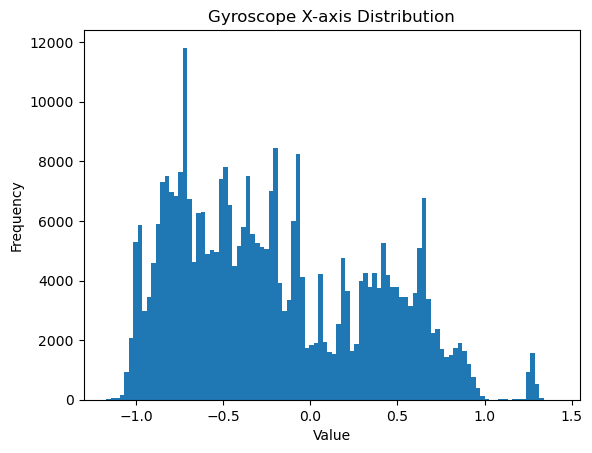

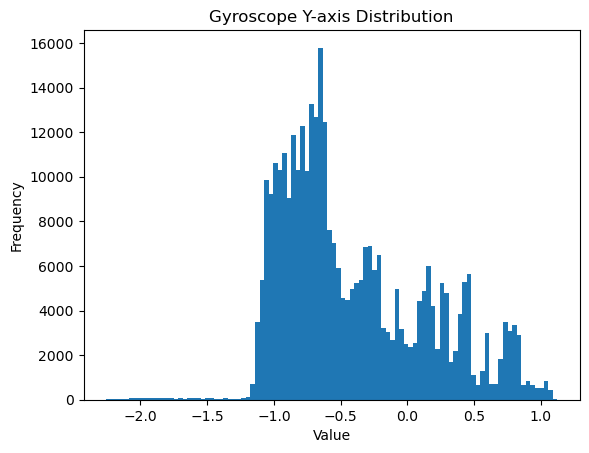

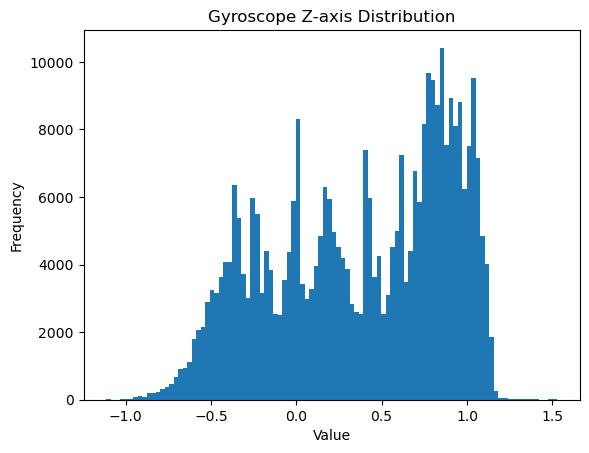

In [ ]:
# 데이터 분포 확인 (예시로 히스토그램 그리기)
import matplotlib.pyplot as plt

# 자이로스코프 X축 데이터 분포
plt.hist(X_raw_mhealth[:, 0], bins=100)
plt.title('Gyroscope X-axis Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# 자이로스코프 Y축 데이터 분포
plt.hist(X_raw_mhealth[:, 1], bins=100)
plt.title('Gyroscope Y-axis Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# 자이로스코프 Z축 데이터 분포
plt.hist(X_raw_mhealth[:, 2], bins=100)
plt.title('Gyroscope Z-axis Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# 3. MergeData.csv 데이터 처리 및 전처리
***
## 3.1 MergeData.csv를 Parquet로 변환하여 저장 (데이터 저장 형식 최적화)

In [ ]:
import os
import gc
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm

# CSV를 Parquet로 변환
csv_file = './data/MergeData.csv'
parquet_file = './real_time_model_optimized/MergeData.parquet'

# 기존 Parquet 파일 삭제
if os.path.exists(parquet_file):
    os.remove(parquet_file)
    logger.info("기존 Parquet 파일을 삭제했습니다.")

logger.info("Converting MergeData.csv to MergeData.parquet...")
chunksize = 10 ** 6  # 1,000,000 행씩 처리

reader = pd.read_csv(csv_file, chunksize=chunksize,
                     usecols=['X', 'Y', 'Z'],
                     dtype={'X': np.float32, 'Y': np.float32, 'Z': np.float32})

# ParquetWriter 초기화 변수를 None으로 설정
writer = None

for i, chunk in enumerate(tqdm(reader, desc="Converting CSV to Parquet")):
    chunk.dropna(inplace=True)
    valid_indices = (chunk[['X', 'Y', 'Z']] >= -1000).all(axis=1) & (chunk[['X', 'Y', 'Z']] <= 1000).all(axis=1)
    chunk = chunk[valid_indices]
    chunk.reset_index(drop=True, inplace=True)
    
    if not chunk.empty:
        # PyArrow Table로 변환
        table = pa.Table.from_pandas(chunk)
        
        if writer is None:
            # 첫 번째 청크에서 ParquetWriter 초기화
            writer = pq.ParquetWriter(parquet_file, table.schema)
        
        writer.write_table(table)
        
        # 메모리에서 청크 제거
        del chunk, valid_indices, table
        gc.collect()
    else:
        logger.warning(f"청크 {i}에 유효한 데이터가 없습니다. 이 청크는 건너뜁니다.")

if writer:
    writer.close()
    logger.info("Conversion to Parquet completed.")
else:
    logger.error("유효한 데이터가 없어 Parquet 파일을 생성하지 못했습니다.")

2024-10-18 23:20:41,661 - INFO - 기존 Parquet 파일을 삭제했습니다.
2024-10-18 23:20:41,662 - INFO - Converting MergeData.csv to MergeData.parquet...
Converting CSV to Parquet: 276it [04:29,  1.02it/s]
2024-10-18 23:25:11,054 - INFO - Conversion to Parquet completed.


- CSV 파일을 청크 단위로 로드하여 메모리 사용량을 줄입니다.
- 각 청크에서 결측값과 이상치를 제거합니다.
- 처리된 청크를 Parquet 파일에 바로 저장하고, 메모리에서 청크를 제거하여 메모리를 관리합니다.
- gc.collect()를 호출하여 가비지 컬렉션을 유도합니다.

# 3.2 데이터 검증 및 전처리

In [ ]:
import pyarrow.parquet as pq
import pyarrow as pa
import matplotlib.pyplot as plt
import os

# Parquet 파일에서 데이터 로드 및 검증
parquet_file = './real_time_model_optimized/MergeData.parquet'

# 파일 존재 여부 확인
if os.path.exists(parquet_file):
    file_size = os.path.getsize(parquet_file)
    logger.info(f"Parquet 파일 크기: {file_size} bytes")
    if file_size == 0:
        logger.error("Parquet 파일의 크기가 0바이트입니다. 데이터를 저장하는 과정에서 문제가 발생한 것 같습니다.")
    else:
        logger.info("Parquet 파일이 정상적으로 생성되었습니다.")
else:
    logger.error("Parquet 파일이 존재하지 않습니다. 데이터를 저장하는 과정에서 문제가 발생한 것 같습니다.")


logger.info("Loading and validating MergeData.parquet...")

# ParquetFile 객체 생성
parquet = pq.ParquetFile(parquet_file)

# 첫 번째 row group만 읽기
table = parquet.read_row_groups([0], columns=['X', 'Y', 'Z'])

# Pandas DataFrame으로 변환
df_sample = table.to_pandas()

# 필요한 행 수만큼 슬라이싱
df_sample = df_sample.head(100000)

# 데이터 분포 확인
plt.hist(df_sample['X'], bins=100)
plt.title('MergeData Gyroscope X-axis Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# 이상치 제거 기준 설정 (예: -50 ~ 50 사이의 값만 사용)
valid_indices = (df_sample[['X', 'Y', 'Z']] >= -50).all(axis=1) & (df_sample[['X', 'Y', 'Z']] <= 50).all(axis=1)
df_sample = df_sample[valid_indices]

logger.info(f"Valid data count after removing outliers: {len(df_sample)}")

# 메모리에서 샘플 데이터 제거
del df_sample, valid_indices, table, parquet
gc.collect()

- Parquet 파일에서 일부 샘플을 로드하여 데이터 검증을 수행합니다.
- 데이터의 분포를 확인하고, 이상치를 제거합니다.
- 사용하지 않는 변수들을 삭제하고 메모리를 관리합니다.

# 4. 데이터셋 결합 및 스케일링 (메모리 관리 적용)

In [ ]:
# MHealth 데이터와 MergeData 결합
logger.info("Combining MHealth data with MergeData...")
parquet_file = './real_time_model_optimized/MergeData.parquet'

X_list_merge = []

for df_chunk in tqdm(pd.read_parquet(parquet_file, columns=['X', 'Y', 'Z'], engine='pyarrow', chunksize=10 ** 6),
                     desc="Loading MergeData.parquet"):
    # 결측값 및 이상치 제거는 이미 Parquet 저장 시 처리되었으므로 생략 가능
    gyro_data = df_chunk[['X', 'Y', 'Z']].values.astype(np.float32)
    X_list_merge.append(gyro_data)
    # 메모리에서 청크 제거
    del df_chunk, gyro_data
    gc.collect()

X_raw_merge = np.vstack(X_list_merge)
logger.info(f"전체 MergeData 데이터 크기: {X_raw_merge.shape}")

# 메모리에서 리스트 제거
del X_list_merge
gc.collect()

# 결합
X_total = np.vstack((X_raw_mhealth, X_raw_merge))
y_total = np.hstack((y_raw_mhealth, np.full(X_raw_merge.shape[0], -1, dtype=int)))  # MergeData의 레이블은 -1로 표시

# 메모리에서 원본 데이터 제거
del X_raw_mhealth, X_raw_merge, y_raw_mhealth
gc.collect()

logger.info(f"결합된 데이터 크기: {X_total.shape}")
logger.info(f"결합된 레이블 크기: {y_total.shape}")

# 스케일링
logger.info("Scaling the data...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_total)

# 스케일러 저장
joblib.dump(scaler, './real_time_model_optimized/scaler.pkl')
logger.info("스케일러를 'scaler.pkl'로 저장했습니다.")

# 메모리에서 원본 데이터 제거
del X_total
gc.collect()

- Parquet 파일에서 데이터를 청크 단위로 로드하여 메모리 사용량을 최적화합니다.
- 각 청크 처리 후 메모리에서 데이터를 제거하고 가비지 컬렉션을 유도합니다.
- 데이터 결합 및 스케일링 후 사용하지 않는 변수들을 삭제하여 메모리를 관리합니다.

# 5. 데이터셋 분할 및 데이터 검증

In [ ]:
# 레이블이 있는 데이터만 분리
X_labeled = X_scaled[y_total != -1]
y_labeled = y_total[y_total != -1].astype(int)

logger.info(f"레이블이 있는 데이터 크기: {X_labeled.shape}")

# 메모리에서 사용하지 않는 변수 제거
del y_total, X_scaled
gc.collect()

# 학습 및 검증 데이터 분할
logger.info("Splitting labeled data into training and validation sets...")
X_train, X_val, y_train, y_val = train_test_split(
    X_labeled,
    y_labeled,
    test_size=0.2,
    random_state=42,
    stratify=y_labeled
)

# 메모리에서 사용하지 않는 변수 제거
del X_labeled, y_labeled
gc.collect()

# 학습 데이터와 검증 데이터의 분포 비교
train_labels, train_counts = np.unique(y_train, return_counts=True)
val_labels, val_counts = np.unique(y_val, return_counts=True)

import matplotlib.pyplot as plt

plt.bar(train_labels, train_counts, alpha=0.5, label='Train')
plt.bar(val_labels, val_counts, alpha=0.5, label='Validation')
plt.legend()
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Class Distribution in Train and Validation Sets')
plt.show()

- 학습 데이터와 검증 데이터의 클래스 분포를 비교하여 데이터가 균등하게 분할되었는지 확인합니다.
- 사용하지 않는 변수들을 삭제하고 메모리를 관리합니다.

# 6. 모델 정의 및 학습
***
## 6.1 MobileNetV2 1D 모델 구현

In [ ]:
class InvertedResidual1D(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual1D, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers = []
        if expand_ratio != 1:
            # 확장 단계
            layers.append(nn.Conv1d(inp, hidden_dim, kernel_size=1, bias=False))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU6(inplace=True))
            
        # 깊이별 컨볼루션
        layers.extend([
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU6(inplace=True),
            
            # 투영 단계
            nn.Conv1d(hidden_dim, oup, kernel_size=1, bias=False),
            nn.BatchNorm1d(oup),
        ])
        self.conv = nn.Sequential(*layers)
        self.out_channels = oup

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class MobileNetV2_1D(nn.Module):
    def __init__(self, num_classes=12, width_mult=1.0):
        super(MobileNetV2_1D, self).__init__()
        block = InvertedResidual1D
        input_channel = 32
        last_channel = 1280

        # 설정된 configuration
        inverted_residual_setting = [
            # t(expand_ratio), c(output channels), n(number of blocks), s(stride)
            [1, 16, 1, 1],
            [6, 24, 2, 1],  # stride를 1로 설정하여 입력 데이터의 길이가 너무 작아지지 않도록 합니다.
            [6, 32, 3, 2],
            [6, 64, 4, 1],
            [6, 96, 3, 1],
            [6, 160, 3, 1],
            [6, 320, 1, 1],
        ]

        # 첫 번째 레이어
        input_channel = int(input_channel * width_mult)
        self.last_channel = int(last_channel * max(1.0, width_mult))
        features = [nn.Conv1d(3, input_channel, kernel_size=3, stride=1, padding=1, bias=False),
                    nn.BatchNorm1d(input_channel),
                    nn.ReLU6(inplace=True)]

        # inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = int(c * width_mult)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel

        # 마지막 몇 개 레이어
        features.append(nn.Conv1d(input_channel, self.last_channel, kernel_size=1, bias=False))
        features.append(nn.BatchNorm1d(self.last_channel))
        features.append(nn.ReLU6(inplace=True))

        self.features = nn.Sequential(*features)

        # 분류를 위한 풀링과 fully connected layer
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, num_classes),
        )

        # weight 초기화
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        # 글로벌 평균 풀링
        x = F.adaptive_avg_pool1d(x, 1).reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

- MobileNetV2의 모든 블록을 1D 버전으로 구현하였습니다.
- 입력 데이터의 길이가 너무 작아지지 않도록 일부 stride를 1로 설정하였습니다.
- 자이로스코프 데이터(X, Y, Z 축)를 입력으로 받으므로 입력 채널 수는 3입니다.
- 클래스 수는 MHealth 데이터셋의 활동 수인 12로 설정하였습니다.

## 6.2 모델 프루닝 적용

In [ ]:
from torch.nn.utils import prune

# 프루닝을 적용할 함수 정의
def apply_pruning(model, amount=0.3):
    parameters_to_prune = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv1d) or isinstance(module, nn.Linear):
            parameters_to_prune.append((module, 'weight'))

    # 글로벌 프루닝 적용
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=amount,
    )

    # 프루닝 후 마스크 제거 (속도 향상을 위해)
    for module, _ in parameters_to_prune:
        prune.remove(module, 'weight')

# 모델 초기화
num_classes = 12  # MHealth 데이터셋의 활동 수
model = MobileNetV2_1D(num_classes=num_classes)
model.to(device)

# 모델 프루닝 적용
apply_pruning(model, amount=0.3)
logger.info("Model pruning applied with 30% sparsity.")

- apply_pruning 함수를 정의하여 모델에 프루닝을 적용합니다.
- amount=0.3으로 설정하여 전체 가중치의 30%를 제거합니다.
- 프루닝 후 마스크를 제거하여 추론 속도를 향상시킵니다.

## 6.3 지식 증류(Knowledge Distillation) 적용

In [ ]:
# Teacher 모델 (이미 학습된 모델 사용)
teacher_model = MobileNetV2_1D(num_classes=num_classes)

# 여기서는 학습된 모델이 있다고 가정하고, 모델의 가중치를 로드합니다.
teacher_model.load_state_dict(torch.load('./real_time_model_optimized/best_model.pth'))
teacher_model.to(device)
teacher_model.eval()

# Student 모델 (경량화된 모델)
student_model = MobileNetV2_1D(num_classes=num_classes, width_mult=0.5)  # 모델 크기를 줄임
student_model.to(device)

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()
distillation_criterion = nn.KLDivLoss(reduction='batchmean')

optimizer = torch.optim.Adam(student_model.parameters(), lr=0.001)

- Teacher 모델은 이미 학습된 큰 모델입니다.
- Student 모델은 경량화된 모델로, width_mult를 줄여서 채널 수를 감소시킵니다.
- 지식 증류를 위해 교차 엔트로피 손실과 KL Divergence 손실을 사용합니다.

## 6.4 모델 학습 (메모리 관리 적용)

In [ ]:
# 데이터셋 및 데이터로더 생성
class SimpleDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        
    def __len__(self):
        return len(self.y)
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SimpleDataset(X_train, y_train)
val_dataset = SimpleDataset(X_val, y_val)

batch_size = 1024
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0,  # Jupyter 환경에서는 0으로 설정
                          pin_memory=True)
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=0,
                        pin_memory=True)

# 지식 증류를 위한 학습 루프
num_epochs = 50
best_val_loss = float('inf')
patience = 5
counter = 0
temperature = 5.0  # 온도 매개변수

logger.info("Starting knowledge distillation training...")
for epoch in range(num_epochs):
    # 학습 모드
    student_model.train()
    total_loss = 0
    total_correct = 0

    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # 입력 데이터 차원 조정
        X_batch = X_batch.permute(0, 2, 1)

        optimizer.zero_grad()

        # Teacher 모델 예측
        with torch.no_grad():
            teacher_outputs = teacher_model(X_batch)

        # Student 모델 예측
        student_outputs = student_model(X_batch)

        # 손실 계산
        loss_ce = criterion(student_outputs, y_batch)
        loss_kd = distillation_criterion(
            F.log_softmax(student_outputs / temperature, dim=1),
            F.softmax(teacher_outputs / temperature, dim=1)
        ) * (temperature ** 2)
        loss = loss_ce + loss_kd

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(student_outputs, 1)
        total_correct += (preds == y_batch).sum().item()

        # 메모리에서 변수 제거
        del X_batch, y_batch, teacher_outputs, student_outputs, loss_ce, loss_kd, loss, preds
        torch.cuda.empty_cache()

    train_loss = total_loss / len(train_dataset)
    train_acc = total_correct / len(train_dataset)

    # 검증 모드
    student_model.eval()
    total_loss = 0
    total_correct = 0

    with torch.no_grad():
        for X_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            X_batch = X_batch.permute(0, 2, 1)

            outputs = student_model(X_batch)
            loss = criterion(outputs, y_batch)

            total_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            total_correct += (preds == y_batch).sum().item()

            # 메모리에서 변수 제거
            del X_batch, y_batch, outputs, loss, preds
            torch.cuda.empty_cache()

    val_loss = total_loss / len(val_dataset)
    val_acc = total_correct / len(val_dataset)

    # 검증 손실이 개선되었는지 확인하고 모델 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(student_model.state_dict(), './real_time_model_optimized/best_student_model.pth')
        counter = 0
        logger.info(f"Epoch {epoch+1}: 검증 손실이 개선되어 Student 모델을 저장했습니다. Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")
    else:
        counter += 1
        logger.info(f"Epoch {epoch+1}: 검증 손실이 개선되지 않았습니다. Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")
        if counter >= patience:
            logger.info("조기 종료 조건에 도달하여 학습을 종료합니다.")
            break

    # 에포크 결과 출력
    logger.info(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, "
                f"Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.4f}, "
                f"Val Acc: {val_acc*100:.2f}%")

    # 메모리에서 변수 제거
    gc.collect()
    torch.cuda.empty_cache()

- 학습 루프 내에서 사용이 끝난 변수들을 삭제하고 torch.cuda.empty_cache()를 호출하여 GPU 메모리를 해제합니다.
- 에포크가 끝날 때마다 gc.collect()를 호출하여 가비지 컬렉션을 유도합니다.
- 이를 통해 메모리 사용량을 최소화하고, 메모리 오버플로우를 방지합니다.

# 7. 모델 저장 및 배포를 위한 최적화
***
## 7.1 모델 양자화 및 TorchScript 변환

In [ ]:
# 가장 좋은 Student 모델 로드
student_model.load_state_dict(torch.load('./real_time_model_optimized/best_student_model.pth'))
student_model.eval()

# 양자화 적용
quantized_model = quantize_dynamic(
    student_model,  # 모델 객체
    {nn.Linear},  # 양자화할 모듈 타입
    dtype=torch.qint8  # 양자화 데이터 타입
)

# TorchScript로 변환하여 저장
example_input = torch.randn(1, 3, 1)  # 예시 입력 데이터
traced_script_module = torch.jit.trace(quantized_model, example_input)

traced_script_module.save('./real_time_model_optimized/model_scripted.pt')
logger.info("TorchScript 모델을 './real_time_model_optimized/model_scripted.pt'로 저장했습니다.")

- Student 모델에 양자화를 적용하여 모델 크기를 줄이고 추론 속도를 향상시킵니다.
- TorchScript로 변환하여 배포에 용이하도록 합니다.

# 8. 실시간 예측 함수 구현 및 최적화

In [ ]:
def real_time_predict(model, scaler, data_point):
    """
    실시간으로 단일 데이터 포인트를 예측합니다.

    Parameters:
        model (torch.jit.ScriptModule): TorchScript로 변환된 모델.
        scaler (object): 스케일러 객체.
        data_point (numpy array): (1, num_features) 형태의 데이터 포인트.

    Returns:
        str: 예측된 활동 이름.
    """
    
    model.eval()
    data_point_scaled = scaler.transform(data_point)
    data_tensor = torch.tensor(data_point_scaled, dtype=torch.float32).to(device)
    data_tensor = data_tensor.permute(0, 2, 1)  # (1, channels, sequence_length)
    with torch.no_grad():
        output = model(data_tensor)
        _, pred = torch.max(output, 1)
    class_names = ['Standing',
                   'Sitting',
                   'Lying',
                   'Walking',
                   'Climbing Stairs',
                   'Waist Bends Forward',
                   'Frontal Elevation of Arms',
                   'Knees Bending',
                   'Cycling',
                   'Jogging',
                   'Running', 
                   'Jumping Front & Back']
    return class_names[pred.item()]

In [ ]:
# 스케일러 및 TorchScript 모델 로드
scaler = joblib.load('./real_time_model_optimized/scaler.pkl')
model = torch.jit.load('./real_time_model_optimized/model_scripted.pt')
model.to(device)
model.eval()

# 실시간 데이터 포인트 (예시)
new_data_point = np.array([[0.1, -0.05, 0.03]])  # 자이로스코프 X, Y, Z 값

# 예측
predicted_activity = real_time_predict(model, scaler, new_data_point)
print(f"예측된 활동: {predicted_activity}")

# 9. MergeData.parquet 데이터에 대한 예측 및 레이블 추가 (메모리 관리 적용)
***
## 9.1 MergeData.parquet 데이터 로드 및 예측

In [ ]:
import pyarrow.parquet as pq
import pyarrow as pa

logger.info("Starting prediction on MergeData.parquet in chunks...")
# 필요한 컬럼 지정
usecols = ['X', 'Y', 'Z']

# 결과를 바로 Parquet 파일로 저장하기 위해 PyArrow를 사용합니다.
output_file = './real_time_model_optimized/MergeData_Prediction.parquet'
writer = None

parquet_file = './real_time_model_optimized/MergeData.parquet'

# Parquet 파일의 총 행 수 계산
parquet_metadata = pq.read_metadata(parquet_file)
nrows = parquet_metadata.num_rows

chunksize = 10 ** 6  # 청크 크기 설정

for i in tqdm(range(0, nrows, chunksize), desc="Predicting MergeData.parquet"):
    df_chunk = pd.read_parquet(parquet_file, columns=usecols, engine='pyarrow', 
                               filters=[('index', '>=', i), ('index', '<', i + chunksize)])

    # 결측값 및 이상치 제거는 이미 처리되었으므로 생략 가능
    gyro_data = df_chunk.values.astype(np.float32)

    # 스케일링
    gyro_data_scaled = scaler.transform(gyro_data)

    # 데이터 텐서로 변환
    data_tensor = torch.tensor(gyro_data_scaled, dtype=torch.float32).to(device)
    data_tensor = data_tensor.permute(0, 2, 1)  # (batch_size, channels, sequence_length)

    # 모델 예측
    with torch.no_grad():
        outputs = model(data_tensor)
        _, preds = torch.max(outputs, 1)

    # 예측 결과를 클래스 이름으로 변환
    class_names = ['Standing', 'Sitting', 'Lying', 'Walking', 'Climbing Stairs', 'Waist Bends Forward',
                   'Frontal Elevation of Arms', 'Knees Bending', 'Cycling', 'Jogging', 'Running', 'Jumping Front & Back']
    predicted_activities = [class_names[pred.item()] for pred in preds]

    # 예측 결과를 데이터프레임에 추가
    df_chunk = df_chunk.iloc[:len(predicted_activities)]  # 예측된 샘플 수에 맞게 슬라이싱
    df_chunk['PredictedActivity'] = predicted_activities

    # 결과를 Parquet 파일로 저장
    table = pa.Table.from_pandas(df_chunk)
    if writer is None:
        writer = pq.ParquetWriter(output_file, table.schema)
    writer.write_table(table)

    # 메모리에서 데이터 제거
    del df_chunk, gyro_data, gyro_data_scaled, data_tensor, outputs, preds, predicted_activities
    gc.collect()
    torch.cuda.empty_cache()

if writer:
    writer.close()
logger.info("Prediction on MergeData.parquet 완료.")

- 각 청크를 처리한 후 결과를 바로 Parquet 파일에 저장하고, 메모리에서 데이터를 삭제하여 메모리를 관리합니다.
- gc.collect()와 torch.cuda.empty_cache()를 사용하여 메모리를 해제합니다.